# The Variational Quantum Linear Solver

In [10]:
# FOR GOOGLE COLAB ONLY:
# Install required packages
# !pip install matplotlib==3.10.6 \
#              pennylane==0.37.0 \
#              pyscf==2.10.0 \ºº
#              pylatexenc==2.10 \
#              ipykernel==6.30.1 \
#              qiskit-ibm-runtime==0.43.1 \
#              qiskit-aer==0.17.2 \
#              qiskit-nature==0.7.2 \
#              scikit-learn==1.7.2 \
#              qiskit-ibm-catalog==0.11.0 \
#              qiskit-serverless==0.27.1

In [11]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister,  ClassicalRegister, transpile
from qiskit_aer import AerSimulator # Aer + assemble
from qiskit_aer.primitives import EstimatorV2, SamplerV2

import math
import random
import numpy as np
from scipy.optimize import minimize

## 1. Introduction

The Variational Quantum Linear Solver, or the VQLS is a variational quantum algorithm that utilizes VQE in order to solve systems of linear equations more efficiently than classical computational algorithms. Specifically, if we are given some matrix $A$, such that $A |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$, where $|\textbf{b}\rangle$ is some known vector, the VQLS algorithm is theoretically able to find a normalized $|x\rangle$ that is proportional to $|\textbf{x}\rangle$, which makes the above relationship true.

The output of this algorithm is identical to that of the HHL Quantum Linear-Solving Algorithm, except, while HHL provides a much more favourable computation speedup over VQLS, the variational nature of our algorithm allows for it to be performed on NISQ quantum computers, while HHL would require much more robust quantum hardware, and many more qubits.


## 2. The Algorithm

To begin, the inputs into this algorithm are evidently the matrix $A$, which we have to decompose into a linear combination of unitaries with complex coefficients:



$$A \ = \ \displaystyle\sum_{n} c_n \ A_n,\quad A |\bold{x}\rangle = |\mathbf{b}\rangle,\quad |\mathbf{b}\rangle=U|0\rangle $$



Where each $A_n$ is some unitary, and some unitary $U$ that prepares state $|\textbf{b}\rangle$ from $|0 \rangle$. Now, recall the general structure of a variational quantum algorithm. We have to construct a quantum cost function, which can be evaluated with a low-depth parameterized quantum circuit, then output to the classical optimizer. This allows us to search a parameter space for some set of parameters $k$, such that $|\psi(k)\rangle \ = \ \frac{|\textbf{x}\rangle}{|| \textbf{x} ||}$, where $|\psi(k)\rangle$ is the output of out quantum circuit corresponding to some parameter set $k$.

Before we actually begin constructing the cost function, let's take a look at a "high level" overview of the sub-routines within this algorithm, as illustrated in this image from the original paper:

![alttext](images/bro.png)

So essentially, we start off with a qubit register, with each qubit initialized to $|0\rangle$. Our algorithm takes its inputs, then prepares and evaluates the cost function, starting with the creation of some ansatz $V(k)$. If the computed cost is greater than some parameter $\gamma$, the algorithm is run again with updated parameters, and if not, the algorithm terminates, and the ansatz is calculated with the optimal parameters (determined at termination). This gives us the state vector that minimizes our cost function, and therefore the normalized form of $|\textbf{x}\rangle$.

## 3. Qiskit Implementation

### Fixed Hardware Ansatz
Let's start off by considering the ansatz $V(k)$, which is just a circuit that prepares some arbitrary state $|\psi(k)\rangle$. This allows us to "search" the state space by varying some set of parameters, $k$. \
The ansatz that we will use for this implementation is given as follows:

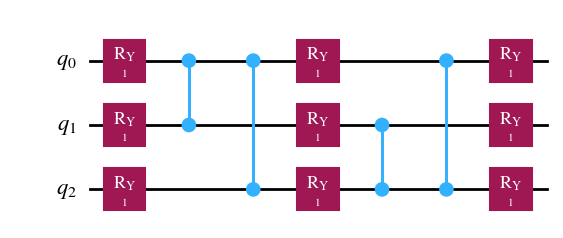

In [12]:
#creates the ansatz |psi_k> = V_k |0>         (vector |0>)

def apply_fixed_ansatz(circ,qubits, parameters):    

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz(circ,[0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw('mpl')

This is called a **fixed hardware ansatz**: the configuration of quantum gates remains the same for each run of the circuit, all that changes are the parameters. Unlike the QAOA ansatz, it is not composed solely of Trotterized Hamiltonians. The applications of $Ry$ gates allow us to search the state space, while the $CZ$ gates create "interference" between the different qubit states. 

Now, it makes sense for us to consider the actual **cost function**. The goal of our algorithm will be to minimize cost, so when $|\Phi\rangle \ = \ A |\psi(k)\rangle$ is very close to $|\textbf{b}\rangle$, we want our cost function's output to be very small, and when the vectors are close to being orthogonal, we want the cost function to be very large. \
Thus, we introduce the '"projection" Hamiltonian' to be minimized:



$$H_P \ = \ \mathbb{I} \ - \ |\mathbf{b}\rangle \langle \mathbf{b}|$$



Then we find that the cost function $C_P$ is the expected value of the Hamiltonian:



$$C_P \ = \ \langle \Phi | H_P | \Phi \rangle \ = \ \langle \Phi | (\mathbb{I} \ - \ |\mathbf{b}\rangle \langle \mathbf{b}|) |\Phi \rangle \ = \ \langle \Phi | \Phi \rangle \ - \ \langle \Phi |\mathbf{b}\rangle \langle \mathbf{b} | \Phi \rangle = {\langle \Phi | \Phi \rangle} - |{\langle \mathbf{b} | \Phi \rangle}|^2$$



Notice how the second term tells us "how much" of $|\Phi\rangle$ lies along $|\mathbf{b}\rangle$. We then subtract this from another number to get the desired low number when the inner product of $|\Phi\rangle$ and $|\mathbf{b}\rangle$ is greater (they agree more), and the opposite for when they are close to being orthogonal. 

Indeed if $|\Phi\rangle$ = $|\mathbf{b}\rangle$ we get $C_P=0$

This is looking good so far! However, there is still one more thing we can do to increase the accuracy of the algorithm: normalizing the cost function. This is due to the fact that if $|\Phi\rangle$ has a small norm, then the cost function will still be low, even if it does not agree with $|\textbf{b}\rangle$. Thus, we replace $|\Phi\rangle$ with $\frac{|\Phi\rangle}{\sqrt{\langle \Phi | \Phi \rangle}}$:



$$\hat{C}_P \ = \ \frac{\langle \Phi | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ - \ \frac{\langle \Phi |\mathbf{b}\rangle \langle \mathbf{b} | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{\langle \Phi |\mathbf{b}\rangle \langle \mathbf{b} | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{|\langle \mathbf{b} | \Phi \rangle|^2}{\langle \Phi | \Phi \rangle}$$



Ok, so, we have prepared our state $|\psi(k)\rangle$ with the ansatz. Now, we have two values to calculate in order to evaluate the cost function, namely $|\langle \mathbf{b} | \Phi \rangle|^2$ and $\langle \Phi | \Phi \rangle$. \

Luckily, a nifty little quantum subroutine called the **Hadamard Test** allows us to do this! Essentially, if we have some unitary $U$ and some state $|\phi\rangle$, and we want to find the expectation value of $U$ with respect to the state, $\langle \phi | U | \phi \rangle$, then we can evaluate the following circuit:

<br><br>

![image1](images/h.png)

<br><br>

Then, the probability of measuring the first qubit to be $0$ is equal to $\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$ and the probability of measuring $1$ is $\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$, so subtracting the two probabilities gives us $\text{Re} \langle U \rangle$. Luckily, the matrices we will be dealing with when we test this algorithm are completely real, so $\text{Re} \langle U \rangle \ = \ \langle U \rangle$, for this specific implementation. 


<details> <summary>
We demonstrate now the proof. 
</summary>
<br>

To construct the Hadamard test, we have as our general state vector:


$$\frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}$$



<br>

Applying our controlled unitary to the second qubit (applied only when the first qubit is in $|1\rangle $):

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}}$$



<br>

Then applying the Hadamard gate to the first qubit:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ U|\psi\rangle \ - \ |1\rangle \ \otimes \ U|\psi\rangle \big]$$



<br>



$$\Rightarrow \ \frac{1}{2} |0\rangle \ \otimes \ (\mathbb{I} \ + \ U)|\psi\rangle \ + \ \frac{1}{2} |1\rangle \ \otimes \ (\mathbb{I} \ - \ U)|\psi\rangle$$



<br>


When we take a measurement of the first qubit, the probability of meausing $|0\rangle$ is:

<br>



$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I} \ + \ U) (\mathbb{I} \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I}^2 \ + U \ + \ U^{\dagger} \ + U U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2\mathbb{I} \ + U \ + \ U^{\dagger}) |\psi\rangle$$



<br>



$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | U^{\dagger} | \psi \rangle \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

By a similar procedure, we get:

<br>



$$P(1)  \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | U | \psi \rangle) = 1-P(0)$$



<br>

And so, by taking the difference we obtain the aforementioned result:

<br>



$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | U | \psi \rangle$$
<br>



Cool! Now, we can actually implement this for the two values we have to compute. 

Let's start with $\langle \Phi | \Phi \rangle$, where we have:

<br>



$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$



<br>

and so our task becomes computing every possible term $\langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$ using the Hadamard test. This requires us to prepare the state $V(k) |0\rangle$, and then perform controlled operations with some control-auxiliary qubits for the unitary matrices $A_m^{\dagger}$ and $A_n$. We can implement this in code:


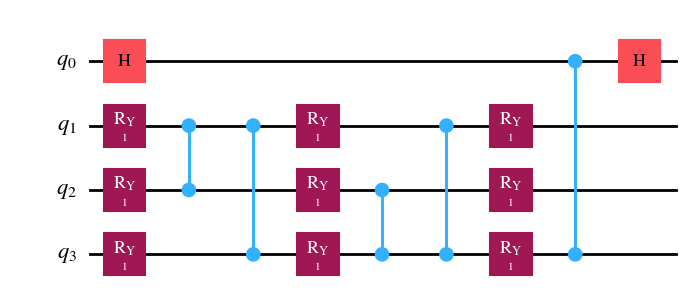

In [13]:
# Creates the Hadamard test to compute  <Phi|Phi> = <U>

def hadamard_test(circ,gate_type, qubits, auxiliary_index, parameters):
    apply_fixed_ansatz(circ,qubits, parameters)

    circ.h(auxiliary_index)
    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
hadamard_test(circ,[[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw('mpl')

The reason why we are applying two different "gate_types" is because this represents the pairs of gates shown in the expanded form of $\langle \Phi | \Phi \rangle$.

It is also important to note that for the purposes of this implementation (the systems of equations we will actually be solving), **we are only concerned with the gates $Z$ and $\mathbb{I}$, so I only include support for these gates. The code includes number "identifiers" that signify the application of different gates, $0$ for $\mathbb{I}$ and $1$ for $Z$)**

Now, we can move on to the second value we must calculate, which is $|\langle \mathbf{b} | \Phi \rangle|^2$. We get:

<br>



$$|\langle \mathbf{b} | \Phi \rangle|^2 \ = \ |\langle \mathbf{b} | A V(k) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(k) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

All we have to do now is the same expansion as before for the product $\langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$:

<br>



$$\langle 0 | U^{\dagger} A V(k) | 0 \rangle^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A_m^{\dagger} U |0\rangle$$



<br>

Now, again, for the purposes of this demonstration, we will soon see that all the outputs/expectation values of our implementation will be real, so we have:
<br>



$$\Rightarrow \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} A V(k) | 0 \rangle)^{*} \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

Thus, in this particular implementation:

<br>



$$|\langle \mathbf{b} | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$



<br>

<!-- There is a sophisticated way of solving for this value, using a newly-proposed subroutine called the **Hadamard Overlap Test** (see cited paper),  -->

For this tutorial we will be using a standard Hadamard Test, where we control each matrix. This unfortunately requires the use of an extra auxiliary qubit. We essentially just place a control on each of the gates involved in the auxiliary, the $|\mathbf{b}\rangle$ preparation unitary, and the $A_n$ unitaries. We get something like this for the controlled-ansatz:


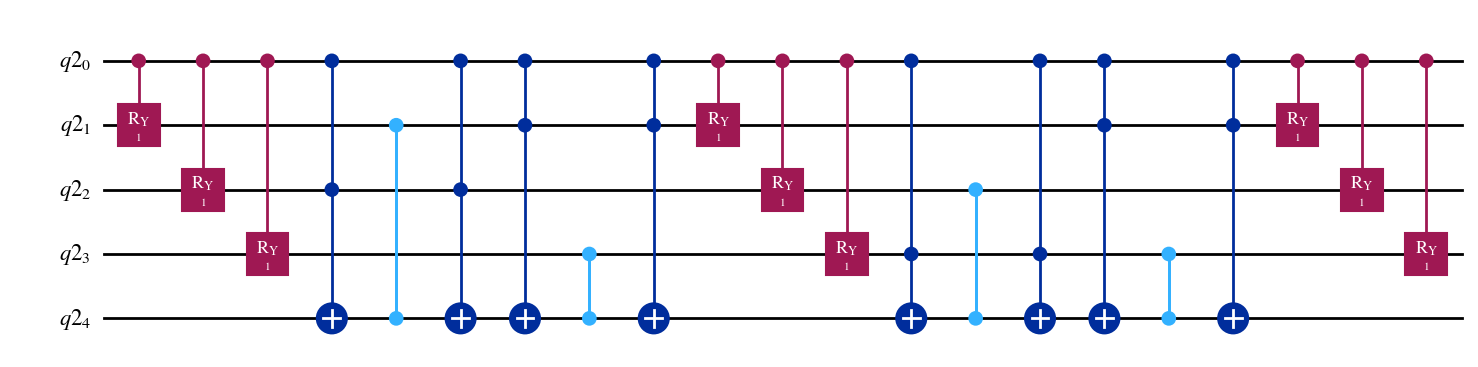

In [14]:
# Creates controlled ansatz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(circ,qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz(circ,[1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw('mpl')

Notice the extra qubit, `q0_4`. This is an auxiliary, and allows us to create a $CCZ$ gate, as is shown in the circuit. Now, we also have to create the circuit for $U$. In our implementation, we will pick $U$ as:

<br>



$$U \ = \ H_1 H_2 H_3$$



<br>

Remember that $|b\rangle = U|0\rangle $ Thus, we have:

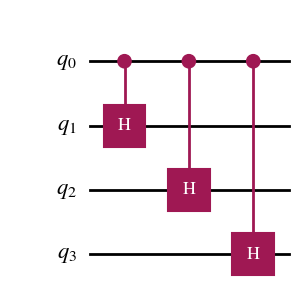

In [15]:
# for creating |b>

def control_b(circ,auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(circ,0, [1, 2, 3])
circ.draw('mpl')

Finally, we construct our new Hadamard test:

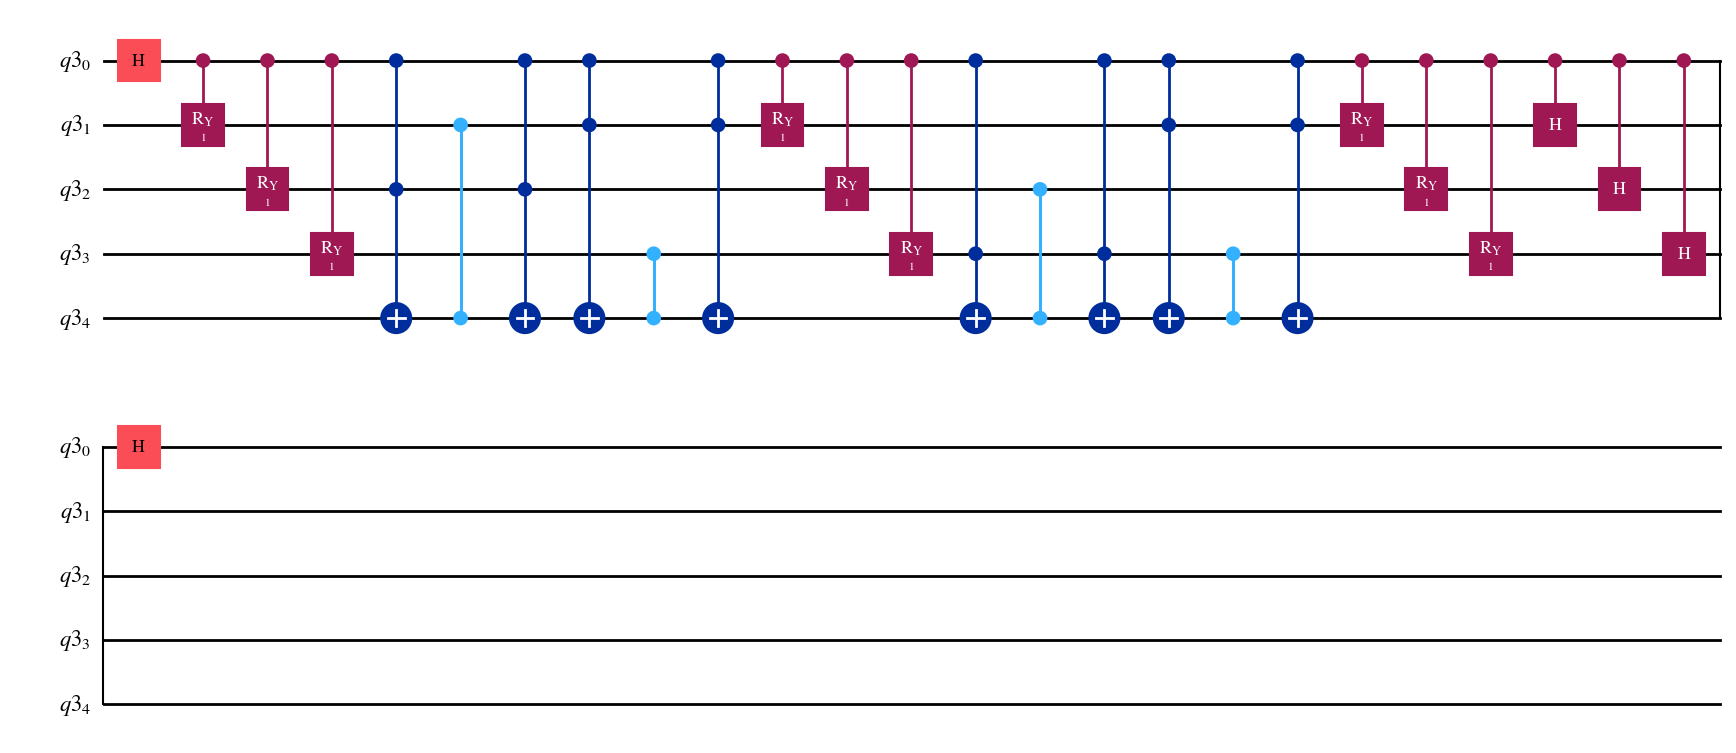

In [16]:
# Create the controlled Hadamard test, for calculating <b|psi>

def special_hadamard_test(circ,gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(circ,qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(circ,auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_hadamard_test(circ,[[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw('mpl')

This is for the specific implementation when all of our parameters are set to $1$, and the set of gates $A_n$ is simply `[0, 0, 0]`, and `[0, 0, 1]`, which corresponds to the identity matrix on all qubits, as well as the $Z$ matrix on the third qubit (with my "code notation").

Now, we are ready to calculate the final cost function. This simply involves us taking the products of all combinations of the expectation outputs from the different circuits, multiplying by their respective coefficients, and arranging into the cost function that we discussed previously!

In [17]:
# CALCULATE COST FUNCTION
import qiskit_aer
from qiskit_aer import AerSimulator
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile

# Previously defined:
# 1. 'hadamard_test' function (for calculating <phi|A_i|psi> or <phi|phi>)
# 2. 'special_hadamard_test' function (for <psi|A_i^dagger A_j|psi>)
# 3. 'gate_set' (list of Pauli operators A_i in the decomposition of matrix A)
# 4. 'coefficient_set' (list of coefficients a_i in the decomposition A = sum(a_i * A_i))

def calculate_cost_function(parameters, coefficient_set, gate_set):
    """
    Calculates the VQLS cost function C(theta) = 1 - ( |<b|phi>|^2 / <phi|phi> )
    where |phi> = A |psi(theta)> and A = sum(a_i * A_i).

    This implementation minimizes the cost function based on the equivalent form:
    C(theta) = 1 - ( |<b|A|psi>|^2 / <A*psi|A*psi> )

    Denominator = <phi|phi> = <psi|A^dagger A|psi>
    Numerator = |<b|phi>|^2 = |<b|A|psi>|^2

    However, the structure suggests the implementation calculates the cost function
    C(theta) = 1 - ( <psi|A^dagger|b><b|A|psi> / <psi|A^dagger A|psi> )
    which simplifies to:
    C(theta) = 1 - ( Numerator_Term / Denominator_Term )
    """
    
    parameters = np.mod(parameters, 2*np.pi)
    # Restructure the 9 flat parameters into the 3 sets of 3 required by the ansatz
    ansatz_parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
    
    # Initialize the statevector simulator, we need the statevector backend
    backend = AerSimulator(method="statevector")
    
    
    # --------------------------------------------------------------------------
    # 1. CALCULATE DENOMINATOR: <phi|phi> = <psi|A^dagger A|psi>
    # Decomposition: <psi|A^dagger A|psi> = sum_i sum_j (a_i * a_j) * <psi|A_i^dagger A_j|psi>
    # --------------------------------------------------------------------------
    
    denominator_sum = 0
    
    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):
            
            # The coefficient factor: a_i * a_j
            coeff_factor = coefficient_set[i] * coefficient_set[j]

            # Initialize a new 5-qubit circ for each pair (i, j)
            qctl = QuantumRegister(5, name='q')
            circ = QuantumCircuit(qctl)
            
            # This 'hadamard_test' prepares the circuit
            # required to measure the expectation value of <psi|A_i^dagger A_j|psi>
            # using the formula for the real part: Re(<b|A|psi>) = 1 - 2 * P(aux=1)
            # The details depend on how 'hadamard_test' is implemented.
            hadamard_test(circ, [gate_set[i], gate_set[j]], [1, 2, 3], 0, ansatz_parameters)

            # --- Simulation ---
            circ.save_statevector()
            t_circ = transpile(circ, backend)
            job = backend.run(t_circ)
            result = job.result()
            
            # Get the final statevector
            final_statevector = result.get_statevector(circ)
            # Take the real part of the statevector components (as done in the original code)
            real_statevector = np.asarray(final_statevector).real

            # --- Extract P(aux=1) ---
            # The Hadamard Test requires measuring the probability of the control
            # qubit (qubit 0) being 1. Since the state is |q4 q3 q2 q1 q0>, 
            # the states where q0=1 are the odd indices (l%2 == 1).
            prob_aux_is_one = 0
            # Iterate through the statevector components
            for index, amplitude in enumerate(real_statevector):
                # Check if the least significant qubit (Qubit 0) is in state 1 (odd index)
                if (index % 2 == 1):
                    # Probability = |amplitude|^2. Since we took the real part, we use (Re(amplitude))^2
                    # Note: Using the real part of the amplitude squared might introduce errors if the phase is significant.
                    prob_aux_is_one += amplitude**2

            # --- Calculate Overlap Term ---
            # The expectation value E = <Z_0> = 1 - 2*P(aux=1)
            # In VQLS, E corresponds to the real part of the inner product term (e.g., Re(<psi|A_i^dagger A_j|psi>))
            inner_product_term = 1 - (2 * prob_aux_is_one)

            # Sum up the contributions to the denominator
            denominator_sum += coeff_factor * inner_product_term

    
    # --------------------------------------------------------------------------
    # 2. CALCULATE NUMERATOR: |<b|phi>|^2 = |<b|A|psi>|^2
    # Decomposition: |<b|A|psi>|^2 = |sum_i (a_i * <b|A_i|psi>)|^2
    # Calculates two inner products: <b|A_i|psi> and <b|A_j|psi>
    # The overall_sum_2 variable corresponds to the Numerator (or the squared overlap)
    # --------------------------------------------------------------------------
    
    numerator_sum = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):
            
            coeff_factor = coefficient_set[i] * coefficient_set[j]
            # 'combined_overlap' will store: <b|A_i|psi> * <b|A_j|psi> (assuming b=b, and the complex conjugate is ignored)
            combined_overlap = 1

            for extra_run in range(0, 2):
                qctl = QuantumRegister(5, name='q')
                circ = QuantumCircuit(qctl)

                # The 'special_hadamard_test' prepares the circ
                # required to measure the expectation value of <b|A_i|psi> or <b|A_j|psi>
                # It takes only one gate_set element as input.
                if (extra_run == 0):
                    # Measure the overlap for the i-th term: <b|A_i|psi>
                    hadamard_gate_A = gate_set[i]
                if (extra_run == 1):
                    # Measure the overlap for the j-th term: <b|A_j|psi>
                    hadamard_gate_A = gate_set[j]

                special_hadamard_test(circ, hadamard_gate_A, [1, 2, 3], 0, ansatz_parameters, qctl)

                # --- Simulation ---
                circ.save_statevector()    
                t_circ = transpile(circ, backend)
                job = backend.run(t_circ)
                result = job.result()

                final_statevector = result.get_statevector(circ)
                real_statevector = np.asarray(final_statevector).real

                # --- Extract P(aux=1) ---
                prob_aux_is_one = 0
                for index, amplitude in enumerate(real_statevector):
                    if (index % 2 == 1):
                        prob_aux_is_one += amplitude**2
                
                # --- Calculate Overlap Term ---
                # The expectation value E = <Z_0> = 1 - 2*P(aux=1)
                inner_product_term = 1 - (2 * prob_aux_is_one)
                
                # Multiply the overlaps for the i-th and j-th terms
                # This assumes Real(overlap) * Real(overlap) approximates Real(|<b|A_i|psi> <b|A_j|psi>|)
                combined_overlap *= inner_product_term

            # Sum up the contributions to the numerator
            numerator_sum += coeff_factor * combined_overlap
    
    
    # --------------------------------------------------------------------------
    # 3. FINAL COST CALCULATION
    # C(theta) = 1 - (Numerator_Term / Denominator_Term)
    # --------------------------------------------------------------------------
    
    cost_value = 1.0 - (numerator_sum / denominator_sum)
    
    print(f"Cost Function Value: {cost_value:.6f} (Num: {numerator_sum:.6f} / Denom: {denominator_sum:.6f})")

    return cost_value

This code may look long and daunting, but it isn't! In this simulation, I'm taking a **numerical** approach, where I'm calculating the amplitude squared of each state corresponding to a measurement of the auxiliary Hadamard test qubit in the $1$ state, then calculating $P(0) \ - \ P(1) \ = \ 1 \ - \ 2P(1) = \langle H_P \rangle _{\psi} $ with that information. \
This is very exact, but is not realistic, as a real quantum device would have to sample the circuit many times to generate these probabilities (I'll discuss sampling later). In addition, this code is not completely optimized (it completes more evaluations of the quantum circuit than it has to), but this is the simplest way in which the code can be implemented, and I will be optimizing it in an update to this tutorial in the near future.

The final step is to actually use this code to solve a real linear system. We will first be looking at the example:

<br>



$$A=\ 0.55 \mathbb{I} + \ 0.45 Z_3  $$



<br>

In order to minimize the cost function, we use the COBYLA optimizer method, which we repeatedly applying. Our search space for parameters is determined by $\frac{k}{1000} \ k \ \in \ \{0, \ 3000\}$, which is initially chosen randomly. We will run the optimizer for $200$ steps, then terminate and apply the ansatz for our optimal parameters, to get our optimized state vector! \
In addition, we will compute some post-processing, to see if our algorithm actually works! In order to do this, we will apply $A$ to our optimal vector $|\psi\rangle_o$, normalize it, then calculate the inner product squared of this vector and the solution vector, $|\mathbf{b}\rangle$! We can put this all into code as: 



In [ ]:
#COBYLA statevector Cost function optimizer
# THIS TOOK 4 minutes charging (9 minutes without charging)
import qiskit_aer

coefficient_set_1 = [0.55, 0.45]
gate_set_1 = [[0, 0, 0], [0, 0, 1]]

x0 = np.random.uniform(0, 2*np.pi, 9)  #initial parameters guess
num_params = len(x0)

out = minimize(lambda x: calculate_cost_function(x, coefficient_set_1,gate_set_1), 
               x0 = x0, 
               method="COBYLA", 
               options={'maxiter':num_params*25})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz(circ, [0, 1, 2], out_f)      #we apply the result of the minimized cost function
circ.save_statevector()

backend = qiskit_aer.Aer.get_backend('aer_simulator_statevector')
t_circ = transpile(circ, backend)

# qobj = assemble(t_circ)
# job = backend.run(qobj)


job = backend.run(t_circ, shots=1024)

result = job.result()
# result = job.result()
psi_o = result.get_statevector(circ, decimals=10)   #this is the optimized statevector |psi_o>


#Check:apply A1 to our optimal vector |psi_o>, normalize it, then calculate the inner product squared of this vector and the solution vector, |b>
a0 = coefficient_set_1[0]*np.identity(8)                          #a0*Id

# TAKE CARE Z3 has to be interpreted reading the qubits backwards!!! in qiskit it is stored as little endian
# so q2 is the more important. |q0 q1 q2> is stored as |q2 q1 q0>
# so Z3 acts on q0 which is qctl[0]. which means that the kron product HAS TO BE FLIPPED
# AxBxC (theoretically)     --->     CxBxA   when acting on qctl 
a1 = coefficient_set_1[1]*np.kron(np.array([[1,0],[0,-1]]) , np.identity(4))           
A1 = np.add(a0, a1)

b = np.ones(8)/np.sqrt(8)   #real solution, theorically |b>   =   A1*|psi_o> / norm(A1*|psi_o>)
print(f"|psi_o>: {psi_o}")
print(f"A1*|psi_o> / norm(A1*|psi_o>): {np.matmul(A1,psi_o) / np.linalg.norm(np.matmul(A1,psi_o))}")
print(f"|b> : {b}")

#Inner product squared: | <b|   *     A1*|psi_o> / norm(A1*|psi_o>) |^2
print( ( np.matmul(b,np.matmul(A1,psi_o)) / np.linalg.norm(np.matmul(A1,psi_o)) )**2 )

norm_x_inverted =  np.matmul(b, np.matmul(A1,psi_o))
quantum_solution_x = psi_o / (norm_x_inverted)
print("quantum solution x: ",quantum_solution_x)
print("real solution x: ", np.linalg.solve(A1,b))

Cost Function Value: 0.802614 (Num: 0.165523 / Denom: 0.838571)
Cost Function Value: 0.901352 (Num: 0.081588 / Denom: 0.827062)
Cost Function Value: 0.768852 (Num: 0.207083 / Denom: 0.895888)
Cost Function Value: 0.776648 (Num: 0.122473 / Denom: 0.548342)
Cost Function Value: 0.745909 (Num: 0.221414 / Denom: 0.871396)
Cost Function Value: 0.687867 (Num: 0.189113 / Denom: 0.605874)
Cost Function Value: 0.882000 (Num: 0.043647 / Denom: 0.369890)
Cost Function Value: 0.760404 (Num: 0.145165 / Denom: 0.605874)
Cost Function Value: 0.909034 (Num: 0.055114 / Denom: 0.605874)
Cost Function Value: 0.517418 (Num: 0.268030 / Denom: 0.555407)
Cost Function Value: 0.559397 (Num: 0.341422 / Denom: 0.774896)
Cost Function Value: 0.642661 (Num: 0.249635 / Denom: 0.698594)
Cost Function Value: 0.557120 (Num: 0.279902 / Denom: 0.632004)
Cost Function Value: 0.513904 (Num: 0.262863 / Denom: 0.540763)
Cost Function Value: 0.508090 (Num: 0.213657 / Denom: 0.434341)
Cost Function Value: 0.504105 (Num: 0.21

KeyboardInterrupt: 

As you can see, our cost function has achieved a fairly low value of `0.012508904735455295` (with max iter reached), and when we calculate the post check, we get `0.9874910952824102`, which agrees perfectly with what we measured, the vectors $\frac{|\Phi\rangle}{||\Phi\rangle||} = \frac{A_1|\psi\rangle_o}{||A_1|\psi\rangle_o||}$ and $|\mathbf{b}\rangle$ are very similar!

Let's do another test! This time, we will keep $|\mathbf{b}\rangle$ the same, but we will have:

<br>



$$A \ = \ 0.55 \mathbb{I} \ + \ 0.3Z_2 \ - \ 0.6 Z_3$$



Again, we run our optimization code:

In [ ]:

#THIS TOOK 9 minutes (7 minutes charging)
coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

x0 = np.random.uniform(0, 2*np.pi, 9)  #initial parameters guess
num_params = len(x0)
out = minimize(
    lambda x: calculate_cost_function(x, coefficient_set_2,gate_set_2), 
    x0=x0, 
    method="COBYLA", 
    options={'maxiter':num_params*30, "disp": True})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz(circ,[0, 1, 2], out_f)
circ.save_statevector()

backend = qiskit_aer.Aer.get_backend('aer_simulator_statevector')
t_circ = transpile(circ, backend)

# qobj = assemble(t_circ)
# job = backend.run(qobj)

job = backend.run(t_circ, shots=1024)
result = job.result()
psi_o = result.get_statevector(circ, decimals=10)

A2_0 = coefficient_set_2[0]*np.identity(8)
A2_1 = coefficient_set_2[1]*np.kron(np.kron(np.identity(2),np.array([[1,0],[0,-1]])), np.identity(2))# Z2 (remember the interchanged kronecker)
A2_2 = coefficient_set_2[2]*np.kron(np.array([[1,0],[0,-1]]) , np.identity(4))  #remember the interchanged kronecker

A2 = A2_0 + A2_1 + A2_2


b = np.ones(8)/np.sqrt(8)   # b = H1H2H3 |000>

print(f"|psi_o>: {psi_o}")
print(f"A2*|psi_o> / norm(A2*|psi_o>): {np.matmul(A2,psi_o) / np.linalg.norm(np.matmul(A2,psi_o))}")
print(f"|b> : {b}")
print( ( np.matmul(b,np.matmul(A2,psi_o)) / np.linalg.norm(np.matmul(A2,psi_o)) )**2 )

norm_x_inverted =  np.matmul(b, np.matmul(A2,psi_o))
quantum_solution_x = psi_o / (norm_x_inverted)
print("quantum solution x: ",quantum_solution_x)
print("real solution x: ", np.linalg.solve(A2,b))

Cost Function Value: 0.979367 (Num: 0.003912 / Denom: 0.189589)
Cost Function Value: 0.978362 (Num: 0.004766 / Denom: 0.220244)
Cost Function Value: 0.923156 (Num: 0.012564 / Denom: 0.163501)
Cost Function Value: 0.977501 (Num: 0.006452 / Denom: 0.286760)
Cost Function Value: 0.998490 (Num: 0.000359 / Denom: 0.237594)
Cost Function Value: 0.991317 (Num: 0.002198 / Denom: 0.253161)
Cost Function Value: 0.952801 (Num: 0.005880 / Denom: 0.124584)
Cost Function Value: 0.989748 (Num: 0.001676 / Denom: 0.163501)
Cost Function Value: 0.997505 (Num: 0.000673 / Denom: 0.269615)
Cost Function Value: 0.857760 (Num: 0.017214 / Denom: 0.121020)
Cost Function Value: 0.562280 (Num: 0.072593 / Denom: 0.165844)
Cost Function Value: 0.574363 (Num: 0.152603 / Denom: 0.358529)
Cost Function Value: 0.936768 (Num: 0.010507 / Denom: 0.166168)
Cost Function Value: 0.502452 (Num: 0.080777 / Denom: 0.162350)
Cost Function Value: 0.399800 (Num: 0.252231 / Denom: 0.420246)
Cost Function Value: 0.491982 (Num: 0.17

Again, very low error, and the classical cost function agrees! Great, so it works!

Now, we have found that this algorithm works **in theory**. I tried to run some simulations with a circuit that samples the circuit instead of calculating the probabilities numerically. 

Now, let's try to **sample** the quantum circuit, as a real quantum computer would do! 

For some reason, this simulation would only converge somewhat well for a ridiculously high number of "shots" (runs of the circuit, in order to calculate the probability distribution of outcomes). I think that this is mostly to do with limitations in the classical optimizer (COBYLA), due to the noisy nature of sampling a quantum circuit (a measurement with the same parameters won't always yield the same outcome). 

Luckily, there are other optimizers that are built for noisy functions, such as SPSA, but we won't be looking into that in this tutorial. Let's try our sampling for our second value of $A$, with the same matrix $U$:
$$A \ = \ 0.55 \mathbb{I} \ + \ 0.225 Z_2 \ + \ 0.225 Z_3$$

In [18]:
#CALCULATE COST FUNCTION SAMPLING
# generated function
# Previously defined:
# 1. 'hadamard_test' function (for circ construction to measure <psi|A_i^dagger A_j|psi>)
# 2. 'special_hadamard_test' function (for circ construction to measure <b|A_i|psi>)
# 3. 'gate_set' (list of Pauli operators A_i)
# 4. 'coefficient_set' (list of coefficients a_i)
# 5. The ClassicalRegister size (1) is sufficient to measure Qubit 0.


def calculate_cost_function_sampling(parameters,shots, coefficient_set, gate_set, cost_history):
    """
    Calculates the VQLS cost function C(theta) = 1 - ( Numerator / Denominator )
    using a measurement/sampling approach 

    The expectation value Re(<overlap>) is derived from measurement counts:
    <Cp> = 1 - 2 * P(aux=1) = 1 - 2 * (counts['1'] / shots).
    """
    
    parameters = np.mod(parameters, 2*np.pi)
 
    # Restructure the 9 flat parameters into the 3 sets of 3 required by the ansatz
    ansatz_parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
    
    # Initialize the simulator 
    backend = AerSimulator() 
    
    # --------------------------------------------------------------------------
    # 1. CALCULATE DENOMINATOR: <phi|phi> = <psi|A^dagger A|psi>
    # Decomposition: <psi|A^dagger A|psi> = sum_i sum_j (a_i * a_j) * <psi|A_i^dagger A_j|psi>
    # --------------------------------------------------------------------------
    
    denominator_sum = 0
    
    for i in range(len(gate_set)):
        for j in range(len(gate_set)):
            
            # The coefficient factor: a_i * a_j
            coeff_factor = coefficient_set[i] * coefficient_set[j]

            # Initialize a new 5-qubit quantum register and 1-bit classical register (for Qubit 0)
            qctl = QuantumRegister(5, name='q')
            creg = ClassicalRegister(1, name='c')
            circ = QuantumCircuit(qctl, creg)
            
            # Build the specific Hadamard Test circ for the (i, j) term
            hadamard_test(circ, [gate_set[i], gate_set[j]], [1, 2, 3], 0, ansatz_parameters)

            # Mandatory: Measure the control qubit (Qubit 0) into the classical bit (Bit 0)
            circ.measure(0, 0)
            
            # --- Simulation ---
            t_circ = transpile(circ, backend)
            job = backend.run(t_circ, shots=shots) 
            result = job.result()
            
            # Get the measurement counts (e.g., {'0': 9500, '1': 500})
            counts = result.get_counts()
            
            # --- Extract P(aux=1) ---
            # Get the number of times the auxiliary qubit (Qubit 0) was measured as '1'
            count_one = counts.get('1', 0) # Use .get to safely return 0 if '1' is not in keys
            
            #3
            
            # Calculate the probability P(aux=1)
            prob_aux_is_one = count_one / shots
            
            # --- Calculate Inner Product Term ---
            # Expectation value <Z0> = 1 - 2 * P(aux=1)
            inner_product_term = 1 - (2 * prob_aux_is_one)

            # Sum up the contributions to the denominator
            denominator_sum += coeff_factor * inner_product_term

    
    # --------------------------------------------------------------------------
    # 2. CALCULATE NUMERATOR: Term proportional to |<b|A|psi>|^2
    # Numerator_sum corresponds to sum_i sum_j (a_i * a_j) * Re(<b|A_i|psi>) * Re(<b|A_j|psi>)
    # --------------------------------------------------------------------------
    
    numerator_sum = 0

    for i in range(len(gate_set)):
        for j in range(len(gate_set)):
            
            coeff_factor = coefficient_set[i] * coefficient_set[j]
            # 'combined_overlap' will store: Re(<b|A_i|psi>) * Re(<b|A_j|psi>)
            combined_overlap = 1

            for measurement_run in range(0, 2): # Loop for measuring A_i then A_j
                
                qctl = QuantumRegister(5, name='q')
                creg = ClassicalRegister(1, name='c')
                circ = QuantumCircuit(qctl, creg)
                
                # Determine which operator's overlap is being measured
                if (measurement_run == 0):
                    hadamard_gate_A = gate_set[i] # Measure A_i overlap
                else:
                    hadamard_gate_A = gate_set[j] # Measure A_j overlap

                # Build the special Hadamard Test circuit
                special_hadamard_test(circ, hadamard_gate_A, [1, 2, 3], 0, ansatz_parameters, qctl)

                # Measure the control qubit (Qubit 0). The state is |q4 q3 q2 q1 q0>
                circ.measure(0, 0)

                # --- Simulation ---
                t_circ = transpile(circ, backend)
                job = backend.run(t_circ, shots=shots)
                result = job.result()

                counts = result.get_counts()
                
                # --- Extract P(aux=1) ---
                count_one = counts.get('1', 0)
                prob_aux_is_one = count_one / shots

                # --- Calculate Inner Product Term ---
                inner_product_term = 1 - (2 * prob_aux_is_one)
                
                # Multiply the term into the product
                combined_overlap *= inner_product_term

            # Sum up the contributions to the numerator
            numerator_sum += coeff_factor * combined_overlap
    
    
    # --------------------------------------------------------------------------
    # 3. FINAL COST CALCULATION
    # C(theta) = 1 - (Numerator_Term / Denominator_Term)
    # --------------------------------------------------------------------------
    
    cost_value = 1.0 - (numerator_sum / denominator_sum)
    
    print(f"Cost Function Value (Sampling): {cost_value:.6f} (Num: {numerator_sum:.6f} / Denom: {denominator_sum:.6f})")

    cost_history.append(cost_value)
    return cost_value

10000
shots: 10000, SIMULATION 1:
Cost Function Value (Sampling): 0.660285 (Num: 0.245244 / Denom: 0.721912)


/home/gregor/anaconda3/envs/vqe-jupyter/lib/python3.12/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 11
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


Cost Function Value (Sampling): 0.777610 (Num: 0.190619 / Denom: 0.857140)
Cost Function Value (Sampling): 0.598204 (Num: 0.481506 / Denom: 1.198384)
Cost Function Value (Sampling): 0.678695 (Num: 0.383262 / Denom: 1.192828)
Cost Function Value (Sampling): 0.547642 (Num: 0.475580 / Denom: 1.051336)
Cost Function Value (Sampling): 0.703951 (Num: 0.382725 / Denom: 1.292776)
Cost Function Value (Sampling): 0.480175 (Num: 0.404106 / Denom: 0.777388)
Cost Function Value (Sampling): 0.678808 (Num: 0.247263 / Denom: 0.769828)
Cost Function Value (Sampling): 0.339234 (Num: 0.324838 / Denom: 0.491608)
Cost Function Value (Sampling): 0.534417 (Num: 0.425457 / Denom: 0.913816)
Cost Function Value (Sampling): 0.347021 (Num: 0.146610 / Denom: 0.224524)
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 11   Least value of F = 0.3392338481066216
The corresponding X is:
[1.61039272 2.2577137  2.48562343 5.05579107 4.82225658 1.97719336
 1.09

/home/gregor/anaconda3/envs/vqe-jupyter/lib/python3.12/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 11
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


Cost Function Value (Sampling): 0.778820 (Num: 0.188507 / Denom: 0.852280)
Cost Function Value (Sampling): 0.599973 (Num: 0.479689 / Denom: 1.199140)
Cost Function Value (Sampling): 0.671011 (Num: 0.390170 / Denom: 1.185964)
Cost Function Value (Sampling): 0.548869 (Num: 0.471929 / Denom: 1.046104)
Cost Function Value (Sampling): 0.706765 (Num: 0.378882 / Denom: 1.292080)
Cost Function Value (Sampling): 0.465828 (Num: 0.411522 / Denom: 0.770392)
Cost Function Value (Sampling): 0.682937 (Num: 0.245549 / Denom: 0.774448)
Cost Function Value (Sampling): 0.332883 (Num: 0.327472 / Denom: 0.490876)
Cost Function Value (Sampling): 0.532046 (Num: 0.426142 / Denom: 0.910648)
Cost Function Value (Sampling): 0.360856 (Num: 0.151794 / Denom: 0.237496)
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 11   Least value of F = 0.3328829439614077
The corresponding X is:
[1.61039272 2.2577137  2.48562343 5.05579107 4.82225658 1.97719336
 1.09

/home/gregor/anaconda3/envs/vqe-jupyter/lib/python3.12/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 11
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


Cost Function Value (Sampling): 0.772874 (Num: 0.194153 / Denom: 0.854824)
Cost Function Value (Sampling): 0.600409 (Num: 0.477242 / Denom: 1.194328)
Cost Function Value (Sampling): 0.675767 (Num: 0.384692 / Denom: 1.186468)
Cost Function Value (Sampling): 0.548941 (Num: 0.474264 / Denom: 1.051444)
Cost Function Value (Sampling): 0.701945 (Num: 0.383580 / Denom: 1.286944)
Cost Function Value (Sampling): 0.475313 (Num: 0.409881 / Denom: 0.781192)
Cost Function Value (Sampling): 0.685516 (Num: 0.241925 / Denom: 0.769276)
Cost Function Value (Sampling): 0.349725 (Num: 0.325002 / Denom: 0.499792)
Cost Function Value (Sampling): 0.534698 (Num: 0.426250 / Denom: 0.916072)
Cost Function Value (Sampling): 0.361893 (Num: 0.152957 / Denom: 0.239704)
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 11   Least value of F = 0.3497252473028779
The corresponding X is:
[1.61039272 2.2577137  2.48562343 5.05579107 4.82225658 1.97719336
 1.09

/home/gregor/anaconda3/envs/vqe-jupyter/lib/python3.12/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 11
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


Cost Function Value (Sampling): 0.780703 (Num: 0.188515 / Denom: 0.859636)
Cost Function Value (Sampling): 0.601640 (Num: 0.477039 / Denom: 1.197508)
Cost Function Value (Sampling): 0.677781 (Num: 0.382449 / Denom: 1.186924)
Cost Function Value (Sampling): 0.545667 (Num: 0.478447 / Denom: 1.053076)
Cost Function Value (Sampling): 0.699563 (Num: 0.388545 / Denom: 1.293268)
Cost Function Value (Sampling): 0.480786 (Num: 0.402671 / Denom: 0.775540)
Cost Function Value (Sampling): 0.681523 (Num: 0.246640 / Denom: 0.774436)
Cost Function Value (Sampling): 0.345361 (Num: 0.322478 / Denom: 0.492604)
Cost Function Value (Sampling): 0.531624 (Num: 0.426200 / Denom: 0.909952)
Cost Function Value (Sampling): 0.366057 (Num: 0.149015 / Denom: 0.235060)
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 11   Least value of F = 0.3453609089654166
The corresponding X is:
[1.61039272 2.2577137  2.48562343 5.05579107 4.82225658 1.97719336
 1.09

/home/gregor/anaconda3/envs/vqe-jupyter/lib/python3.12/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 11
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


Cost Function Value (Sampling): 0.781049 (Num: 0.187367 / Denom: 0.855748)
Cost Function Value (Sampling): 0.605461 (Num: 0.475441 / Denom: 1.205056)
Cost Function Value (Sampling): 0.675123 (Num: 0.383651 / Denom: 1.180912)


KeyboardInterrupt: 

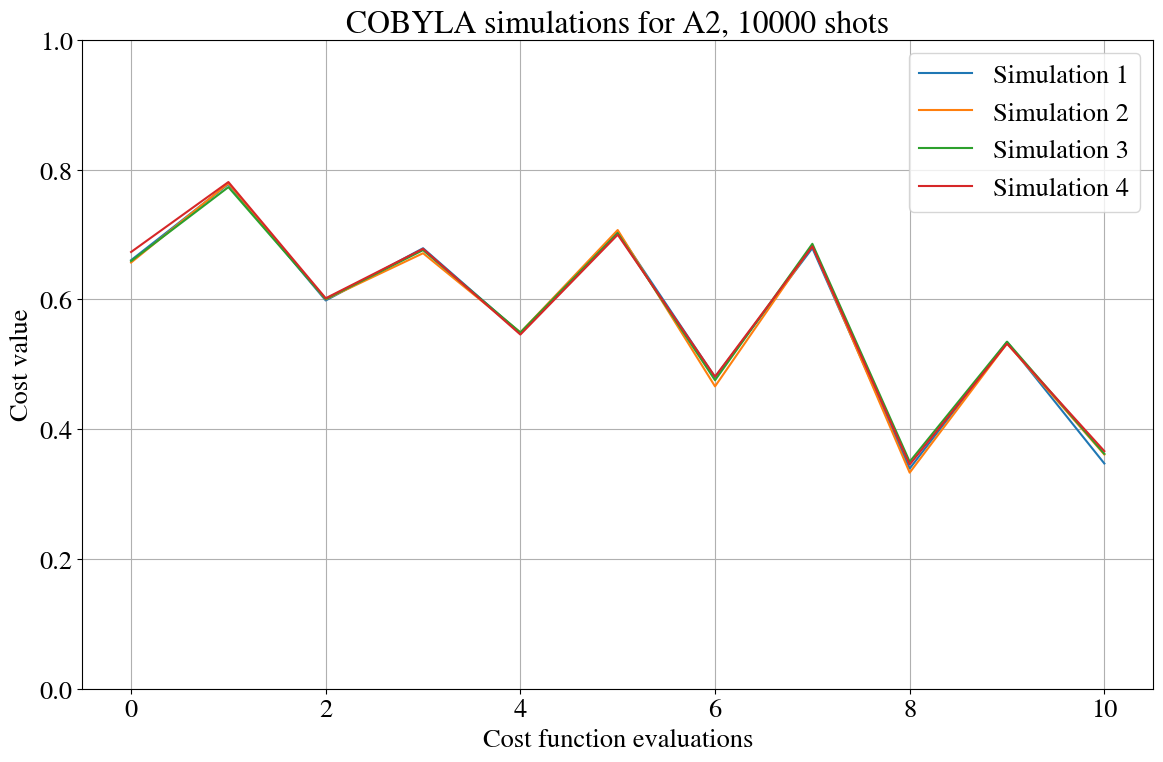

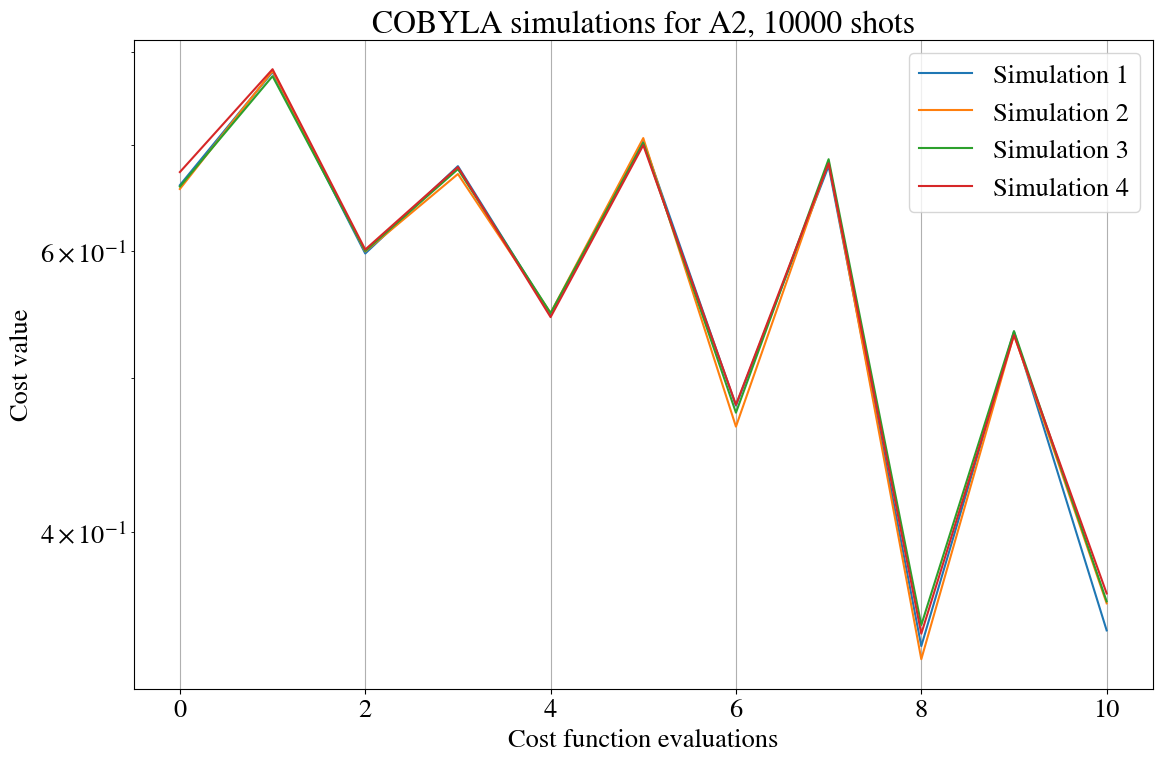

In [ ]:
# Using COBYLA: fast "convergence", but it gets stuck at a high value.
coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

x0 = np.random.uniform(0, 2*np.pi, 9)      #ansatz random parameters
num_params = len(x0)

SHOTS_list = [1024, 10000]

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 19, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

for shots in SHOTS_list:
    x0 = np.random.uniform(0, 2*np.pi, 9)      #ansatz random parameters
    num_params = len(x0)
    fig_COBYLA, ax_COBYLA = plt.subplots(1,1,figsize=(12,8))
    fig2_COBYLA, ax2_COBYLA = plt.subplots(1,1,figsize=(12,8))
    print(shots)
    
    best_cost_overall_COBYLA = np.inf
    best_cost_history_COBYLA = None
    best_output_COBYLA = None
    
    for i in range(1,11):
        print(f"shots: {shots}, SIMULATION {i}:")
        cost_history_temp_COBYLA = []
        
        out_COBYLA = minimize(
            lambda x: calculate_cost_function_sampling(x, shots, coefficient_set_2,gate_set_2,cost_history_temp_COBYLA), 
            x0=x0, 
            method="COBYLA", 
            options={'maxiter':num_params*1, 'disp': True})
        print(out_COBYLA)
        out_f_COBYLA = [out_COBYLA['x'][0:3], out_COBYLA['x'][3:6], out_COBYLA['x'][6:9]]  
        # final_cost_COBYLA = out_COBYLA['fun']
        final_cost_COBYLA = out_COBYLA['fun']
        
        with open(f"vqls/COBYLA/best_cost_history_cobyla_{shots}_{i}.txt", "w") as f:  #overwrites; "a" appends
                f.write("\n".join(str(item) for item in cost_history_temp_COBYLA))
                f.write(f" \n COBYLA MINIMIZATION {i}\n")
                f.write("shots = " + str(shots) + "\n")
                f.write(str(out_COBYLA)+ "\n \n \n \n \n")
        
        if final_cost_COBYLA <= best_cost_overall_COBYLA:
            print("New best simulation")
            cost_history_cobyla_best = cost_history_temp_COBYLA
            best_cost_overall_COBYLA = final_cost_COBYLA
            best_cost_history_COBYLA = cost_history_temp_COBYLA.copy()
              
            with open(f"vqls/COBYLA/best_cost_history_cobyla_{shots}.txt", "w") as f:  #overwrites; "a" appends
                f.write("\n".join(str(item) for item in cost_history_cobyla_best))
                f.write(" \n BEST COBYLA MINIMIZATION \n")
                f.write("shots = " + str(shots) + "\n")
                f.write(str(out_COBYLA)+ "\n \n \n \n \n")
                
        else:
            print("Worse simulation")
        
        import matplotlib.pyplot as plt
        ax_COBYLA.plot(range(len(cost_history_temp_COBYLA)), cost_history_temp_COBYLA, label=f"Simulation {i}")
        ax_COBYLA.grid(True)
        ax_COBYLA.legend()
        ax_COBYLA.set_xlabel("Cost function evaluations"), ax_COBYLA.set_ylabel("Cost value")
        ax_COBYLA.set_ylim(top=1,bottom=0)
        ax_COBYLA.set_title(f"COBYLA simulations for A2, {shots} shots")
        fig_COBYLA.tight_layout()      #VERY IMPORTANT for avoiding cutoff
        fig_COBYLA.savefig(f"vqls/COBYLA/cost_history_COBYLA_{shots}.pdf") 

        ax2_COBYLA.plot(range(len(cost_history_temp_COBYLA)), cost_history_temp_COBYLA, label=f"Simulation {i}")
        ax2_COBYLA.grid(True), ax2_COBYLA.set_yscale("log")
        ax2_COBYLA.legend()
        ax2_COBYLA.set_xlabel("Cost function evaluations"), ax2_COBYLA.set_ylabel("Cost value")
        ax2_COBYLA.set_title(f"COBYLA simulations for A2, {shots} shots")
        fig2_COBYLA.tight_layout()      #VERY IMPORTANT for avoiding cutoff
        fig2_COBYLA.savefig(f"vqls/COBYLA/cost_history_COBYLA_{shots}_log.pdf")
    
    
    
    
    
    
    



In [ ]:

    fig_SPSA, ax_SPSA = plt.subplots(1,1,figsize=(12,8))
    fig2_SPSA, ax2_SPSA = plt.subplots(1,1,figsize=(12,8))
    print(shots)
    
    best_cost_overall_SPSA = np.inf
    best_cost_history_SPSA = None
    best_output_SPSA = None
    
    for i in range(1,3):
        print(f"shots: {shots}, SIMULATION {i}:")
        cost_history_temp_SPSA = []
        
        out_SPSA = minimize(
            lambda x: calculate_cost_function_sampling(x, shots, coefficient_set_2,gate_set_2,cost_history_temp_SPSA), 
            x0=x0, 
            method="SPSA", 
            options={'maxiter':num_params*20, 'disp': True})
        print(out_SPSA)
        out_f_SPSA = [out_SPSA['x'][0:3], out_SPSA['x'][3:6], out_SPSA['x'][6:9]]  
        # final_cost_SPSA = out_SPSA['fun']
        final_cost_SPSA = out_SPSA['fun']
        
        if final_cost_SPSA <= best_cost_simulation_SPSA:
            print("New best simulation")
            cost_history_SPSA_best = cost_history_temp_SPSA
            best_cost_simulation_SPSA = final_cost_SPSA
            best_cost_history_SPSA = cost_history_temp_SPSA.copy()
              
            with open(f"vqls/best_cost_history_SPSA_{shots}.txt", "w") as f:  #overwrites; "a" appends
                f.write("\n".join(str(item) for item in cost_history_SPSA_best))
                f.write(" \n BEST SPSA MINIMIZATION \n")
                f.write("shots = " + str(shots) + "\n")
                f.write(str(out_SPSA)+ "\n \n \n \n \n")
                
        else:
            print("Worse simulation")
        
        import matplotlib.pyplot as plt
        ax_SPSA.plot(range(len(cost_history_temp_SPSA)), cost_history_temp_SPSA, label=f"Simulation {i}")
        ax_SPSA.grid(True)
        ax_SPSA.legend()
        ax_SPSA.set_xlabel("Cost function evaluations"), ax_SPSA.set_ylabel("Cost value")
        ax_SPSA.set_ylim(top=1,bottom=0)
        ax_SPSA.set_title(f"SPSA simulations for A2, {shots} shots")
        fig_SPSA.tight_layout()      #VERY IMPORTANT for avoiding cutoff
        fig_SPSA.savefig(f"vqls/cost_history_SPSA_{shots}.pdf") 

        ax2_SPSA.plot(range(len(cost_history_temp_SPSA)), cost_history_temp_SPSA, label=f"Simulation {i}")
        ax2_SPSA.grid(True), ax2_SPSA.set_yscale("log")
        ax2_SPSA.legend()
        ax2_SPSA.set_xlabel("Cost function evaluations"), ax2_SPSA.set_ylabel("Cost value")
        ax2_SPSA.set_title(f"SPSA simulations for A2, {shots} shots")
        fig2_SPSA.tight_layout()      #VERY IMPORTANT for avoiding cutoff
        fig2_SPSA.savefig(f"vqls/cost_history_SPSA_{shots}_log.pdf")
    
    
    
    fig_SPSA.tight_layout()      #VERY IMPORTANT for avoiding cutoff
    fig_SPSA.savefig(f"vqls/SPSA/cost_history_SPSA_{shots}.pdf") 
    
    
    
    



In [9]:
# #Using Qiskit SPSA: works, but converges slowly 
# #(        *25, 0.1 , 0.1 , False, False, --------, 1, : 36m, maxiter)
# #( 10000, *25, 0.15, 0.15, True , True , --------, 1, : 43m, maxiter) NO
# #( 10000, *25, 0.25, 0.25, True , True , --------, 1, : 43m, maxiter) NO
# #( 10000, *20, 0.20, 0.10, True , True , --------, 1, : 37m, maxiter) NO
# #(  5000, *20, 0.20, 0.10, False, False, --------, 1, : 25m, maxiter)
# #(  1024, *25, 0.20, 0.10, False, False, --------, 1, :  doesnt converge)
# #(  1024, *25, 0.08, 0.10, False, False, --------, 1, :  doesnt converge)
# #(  1024, *25, 0.08, 0.15, True , False, --------, 1, :  doesnt converge)

coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]
x0 = np.random.uniform(0, 2*np.pi, 9)      #ansatz random parameters
num_params = len(x0)



from matplotlib import rcParams
rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def best_x_callback(nfev, parameters, value, stepsize, accepted):   #SPSA callback
    global lowest_cost_SPSA, best_params_SPSA        #keeps track of the best value            
    if 0 < value < lowest_cost_SPSA :               #Conditional update of the best value
        lowest_cost_SPSA = value
        best_params_SPSA = np.copy(parameters)
        print(f"New Best Found: Cost = {value:.6f} at nfev = {nfev}")
        print(f"Parameters: {parameters}")
    return best_params_SPSA, lowest_cost_SPSA 


SHOTS_list = [10000]
for shots in SHOTS_list:
    print(f"Shots: {shots}")
    best_params_SPSA = x0
    lowest_cost_SPSA  = 1
    cost_history_cal = []

    from qiskit_algorithms.optimizers import SPSA
    a,c = 0.25,0.25
    # a, c = SPSA.calibrate(
    #     loss=lambda x: calculate_cost_function_sampling(x, shots, coefficient_set_2, gate_set_2, cost_history_cal),
    #     initial_point=x0,
    #     target_magnitude=0.2,     # recommended for 1024 shots
    #     c=0.15 
    # )
    
    def powerlaw_decay(initial_value, max_iter, power=0.602, stability_constant_ratio=0.1):
        """
        Generator for SPSA power-law decay: value_k = a / (k + A)^alpha
        """
        stability_constant = max_iter * stability_constant_ratio
        # We calibrate 'numerator' so that the first step (k=0) gives exactly 'initial_value'
        # initial_value = numerator / (0 + stability_constant)^power
        # -> numerator = initial_value * (stability_constant^power)
        numerator = initial_value * (stability_constant ** power)
        
        k = 0
        while True:
            yield numerator / ((k + stability_constant) ** power)
            k += 1

    def custom_learning_rate_schedule():
        """
        Custom generator for the learning rate (alpha).
        Strategy: Start high (0.2) and decay faster than standard SPSA to ensure stability at the end.
        """
        
        # Standard SPSA alpha is 0.602. We use a slightly higher power (e.g., 0.65 or 0.7) 
        # to force the rate to drop faster after the initial exploration.
        return powerlaw_decay(initial_value=0.20, max_iter=num_params*25, power=0.602, stability_constant_ratio=0.1)

    def custom_perturbation_schedule():
        """
        Custom generator for the perturbation (epsilon).
        Strategy: Standard decay is usually fine, or keep it relatively constant if noise is high.
        Standard gamma is 0.101.
        """
        return powerlaw_decay(initial_value=0.15, max_iter=num_params*25, power=0.101, stability_constant_ratio=0.1)

    
    spsa = SPSA(
        maxiter=num_params*25,
        learning_rate=custom_learning_rate_schedule,
        perturbation=custom_perturbation_schedule,
        blocking=True,
        trust_region=True,
        # allowed_increase=0.01
        resamplings=1,
        callback=best_x_callback,
        )
    cost_history_SPSA = []

    out = spsa.minimize(
        fun=lambda x: calculate_cost_function_sampling(x,shots,coefficient_set_2,gate_set_2,cost_history_SPSA), 
        x0=x0)
    print(out)
    out_f = [out.x[0:3], out.x[3:6], out.x[6:9]]

    print(f"Best x Found (Tracked by Callback): {best_params_SPSA}...")
    print(f"Best Cost Found (Tracked by Callback): {lowest_cost_SPSA}")
    with open(f"vqls/SPSA/cost_history_SPSA_{shots}.txt", "w") as f:
        f.write("\n".join(str(item) for item in cost_history_SPSA))
        f.write("\n SPSA MINIMIZATION \n")
        f.write("shots = " + str(shots) + "\n")
        f.write(str(out)+ "\n \n")
        f.write("\n Best x Found (Tracked by Callback): " + str(best_params_SPSA) + "\n")
        f.write("Lowest Cost Found (Tracked by Callback): " + str(lowest_cost_SPSA) + "\n \n \n \n")

Shots: 10000
Cost Function Value (Sampling): 0.924099 (Num: 0.082747 / Denom: 1.090192)
Cost Function Value (Sampling): 0.929548 (Num: 0.077868 / Denom: 1.105264)
Cost Function Value (Sampling): 0.921698 (Num: 0.086231 / Denom: 1.101256)


KeyboardInterrupt: 

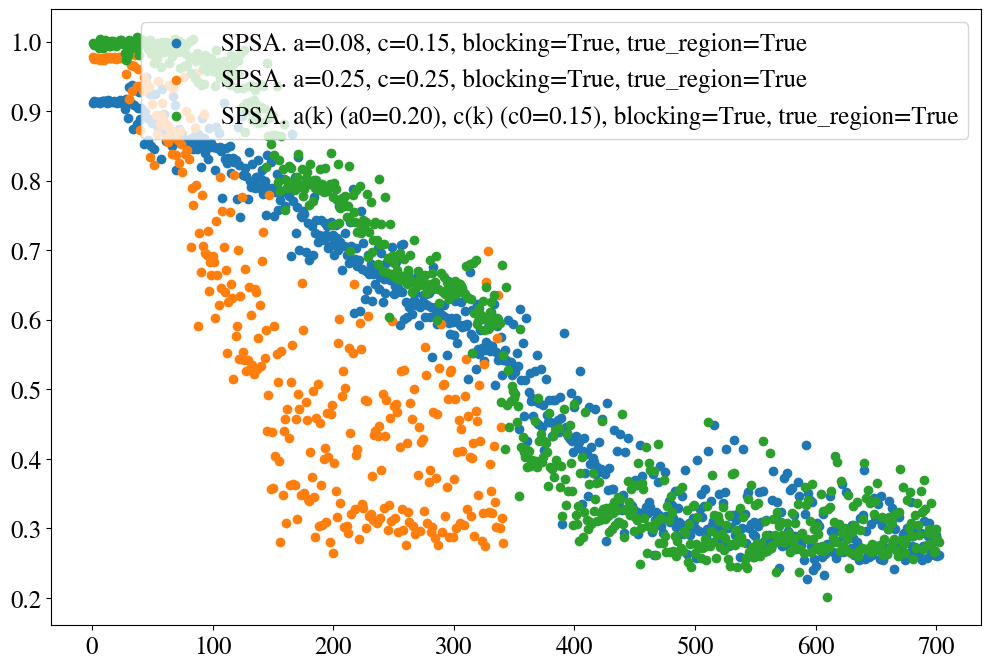

In [31]:
import numpy as np
import matplotlib.pyplot as plt
cost_values_SPSA_1 = np.loadtxt('vqls/SPSA/cost_history_SPSA_10000_1.txt')
cost_values_SPSA_2 = np.loadtxt('vqls/SPSA/cost_history_SPSA_10000_2.txt')
cost_values_SPSA_3 = np.loadtxt('vqls/SPSA/cost_history_SPSA_10000_3.txt',skiprows=14)
iters_1, iters_2, iters_3 = len(cost_values_SPSA_1), len(cost_values_SPSA_2), len(cost_values_SPSA_3)
plt.figure(figsize=(12,8))
plt.scatter(range(1,iters_1+1), cost_values_SPSA_1, label="SPSA. a=0.08, c=0.15, blocking=True, true_region=True")
plt.scatter(range(1,iters_2+1), cost_values_SPSA_2, label="SPSA. a=0.25, c=0.25, blocking=True, true_region=True")
plt.scatter(range(1,iters_3+1), cost_values_SPSA_3, label="SPSA. a(k) (a0=0.20), c(k) (c0=0.15), blocking=True, true_region=True")
plt.legend()
plt.savefig("spsa_results.pdf")

In [ ]:
# USING AMSGRAD SPSA

import numpy as np

class SPSA_AMSGrad:
    def __init__(self, maxiter=200, alpha=0.01, c=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8, twopi_bounds=True):
        """
        Args:
            maxiter: Max iterations.
            alpha: Step size (learning rate).
            c: Perturbation magnitude.
            beta1, beta2: AMSGrad decay rates.
            epsilon: Stability constant.
            twopi_bounds (bool): If True, ensures parameters stay in [0, 2pi) via modulo.
        """
        self.maxiter = maxiter
        self.alpha = alpha
        self.c = c
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.twopi_bounds = twopi_bounds
        
    def minimize_AMSGRAD(self, fun, x0, callback=None):
        # 1. Initialize variables
        x = np.array(x0, dtype=float)
        dim = len(x)
        
        # AMSGrad State variables
        m = np.zeros(dim)
        v = np.zeros(dim)
        v_hat = np.zeros(dim)
        
        cost_history = []
        
        for k in range(self.maxiter):
            # --- A. SPSA Gradient Estimation ---
            delta = 2 * np.random.randint(0, 2, size=dim) - 1
            
            x_plus = x + self.c * delta
            x_minus = x - self.c * delta
            
            loss_plus = fun(x_plus)
            loss_minus = fun(x_minus)
            
            # Estimate Gradient
            ghat = (loss_plus - loss_minus) / (2 * self.c) * delta
            
            # --- B. AMSGrad Update Rule ---
            # Update biased first moment estimate
            m = self.beta1 * m + (1 - self.beta1) * ghat
            
            # Update biased second raw moment estimate
            v = self.beta2 * v + (1 - self.beta2) * (ghat ** 2)
            
            # Use the maximum of v and v_prev (The AMSGrad "Fix")
            v_hat = np.maximum(v_hat, v)
            
            # Update parameters
            update_step = self.alpha * m / (np.sqrt(v_hat) + self.epsilon)
            x = x - update_step
            
            if self.twopi_bounds:
                x = np.mod(x, 2*np.pi)
            
            # --- D. Logging ---
            current_est_cost = (loss_plus + loss_minus) / 2.0
            cost_history.append(current_est_cost)
            
            if callback is not None:
                callback(k, x, current_est_cost)
                
        return {
            "x": x,
            "fun": cost_history[-1],
            "history": cost_history
        }

# --- Setup ---
shots = 1024

# Initialize Custom Optimizer with twopi_bounds enabled
amsGrad = SPSA_AMSGrad(
    maxiter=num_params*25, 
    alpha=0.05,         #learning rate
    c=0.1,              #perturbation
    twopi_bounds=True         # 0-2pi x twopi_bounds
)

# Run
print("Starting Bounded AMSGrad-SPSA...")
cost_history_AMSGRAD = []
out = amsGrad.minimize_AMSGRAD(
    fun= lambda x: calculate_cost_function_sampling(x, shots, coefficient_set_2,gate_set_2,cost_history_AMSGRAD),
    x0=x0
)
print(f"Final result: {out['x']}")

In [ ]:
def compare_quantum_classical(A,out_f):
    
    circ = QuantumCircuit(3, 3)
    apply_fixed_ansatz(circ,[0, 1, 2], out_f)
    circ.save_statevector()
    backend = AerSimulator()
    t_circ = transpile(circ, backend)
    job = backend.run(t_circ)
    result = job.result()
    
    psi_o = np.real(result.get_statevector(circ, decimals=100))
    b = np.ones(8)/np.sqrt(8)   #H1H2H3 * |000>

    print(f"|psi_o>: {psi_o}")
    print(f"A*|psi_o> / norm(A*|psi_o>): {np.matmul(A,psi_o.real) / np.linalg.norm(np.matmul(A,psi_o))}")
    print(f"|b> : {b}")
    print( "overlap: ",( np.matmul(b,np.matmul(A,psi_o)) / np.linalg.norm(np.matmul(A,psi_o)) )**2 )

    norm_x_inverted =  np.matmul(b, np.matmul(A,psi_o))    # <b|A|psi_o> = <b|b>/norm(|x>)
    quantum_solution_x = psi_o / (norm_x_inverted)
    real_solution_x = np.linalg.solve(A,b)
    print()
    print("quantum solution x: ",quantum_solution_x)
    print("real solution x: ", real_solution_x)
    return quantum_solution_x, real_solution_x

In [ ]:
coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

A2_0 = coefficient_set_2[0]*np.identity(8)
A2_1 = coefficient_set_2[1]*np.kron(np.kron(np.identity(2),np.array([[1,0],[0,-1]])), np.identity(2))# remember the interchanged kronecker
A2_2 = coefficient_set_2[2]*np.kron(np.array([[1,0],[0,-1]]) , np.identity(4))  #remember the interchanged kronecker
A2 = A2_0 + A2_1 + A2_2

out_f = [[3.14436877, 1.32364174, 5.08689214], [3.70242808, 5.46174263, 5.07868044],
 [1.00812173, 3.70024916, 2.93959444] ]   #mca_es result
compare_quantum_classical(A2,out_f);


<class 'list'>
|psi_o>: [0.04697438 0.04989195 0.05118328 0.04894461 0.50235431 0.50076582
 0.49357662 0.49350254]
A*|psi_o> / norm(A*|psi_o>): [ 0.12142376  0.12896536  0.05088589  0.04866023  0.09988709  0.09957124
 -0.68699229 -0.68688918]
|b> : [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
overlap:  0.08497253535422204

quantum solution x:  [-0.32042105 -0.34032232 -0.34913073 -0.33386035 -3.42665269 -3.41581733
 -3.36677841 -3.36627311]
real solution x:  [ 0.27196415  0.27196415  0.70710678  0.70710678  3.53553391  3.53553391
 -0.50507627 -0.50507627]


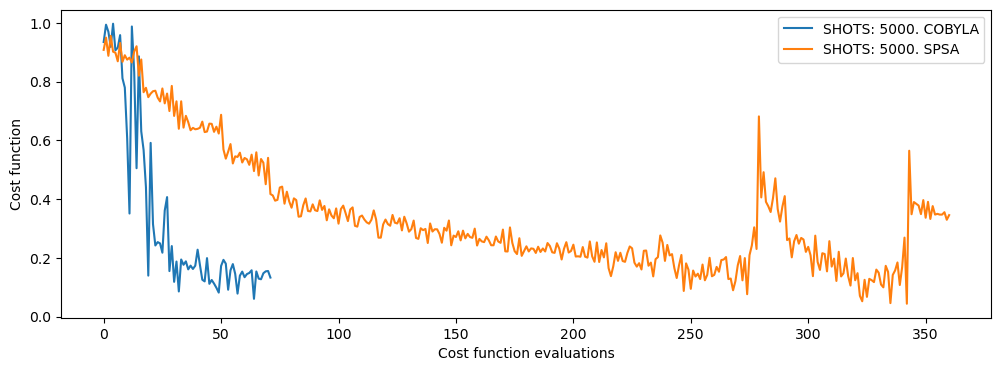

In [ ]:
import matplotlib.pyplot as plt
def plot_cost_history():
    fig, ax = plt.subplots(2,1,figsize=(12,8))
    ax[0].plot(range(len(cost_history_cobyla)), cost_history_cobyla, label=f"SHOTS: 5000. COBYLA")
    ax[0].plot(range(len(cost_history_SPSA)), cost_history_SPSA, label=f"SHOTS: 5000. SPSA")
    ax[0].legend()
    ax[0].set_xlabe l("Cost function evaluations"), ax[0].set_ylabel("Cost value")
plot_cost_history()

This is applied with $A_2$: coefficient_set = [0.3, 0.4, -0,6]. 

Before we got `0.012508904735455295` (with max iter reached), and classical cost function of `0.9874910952824102`.

So as you can see, not amazing, our solution is still off by a fairly significant margin ($~3\%$ error isn't awful, but ideally, we want it to be **much** closer to 0). Again, I think this is due to the optimizer itself, not the actual quantum circuit. I will be making an update to this Notebook once I figure out how to correct this problem (likely with the introduction of a noisy optimizer, as I previously mentioned).


In [22]:
#USING WARMUP
coefficient_set_2 = [0.3, 0.4, -0.6]
gate_set_2 = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]
x0 = np.random.uniform(0, 2*np.pi, 9)  #initial parameters guess
num_params = len(x0)


# import cma
# sigma0 = 0.3   # amplitude of random exploration. works well for angle parameters
# CMA = cma.CMAEvolutionStrategy(x0, 
#                                sigma0,
#                               {'maxiter': num_params*4,   # 60–120 recommended
#                                'verb_disp': 1})

# CMA.optimize(       #USE THE STATEVECTOR FUNCTION
#     objective_fct = lambda x: calculate_cost_function(x,coefficient_set_2,gate_set_2))
# out = CMA.result.xbest


#2 minutes per 60 iters
out = minimize(
    lambda x: calculate_cost_function(x, coefficient_set_2,gate_set_2), 
    x0=x0, 
    method="COBYLA", 
    options={'maxiter':num_params*7, "disp": True})
print(out)
x_warm = out['x']

x_warm_f = [x_warm[0:3], x_warm[3:6], x_warm[6:9]]
print("Warm-up  result:", x_warm)

Cost Function Value: 0.976192 (Num: 0.010700 / Denom: 0.449444)
Cost Function Value: 0.967079 (Num: 0.016158 / Denom: 0.490812)
Cost Function Value: 0.998708 (Num: 0.000622 / Denom: 0.481169)
Cost Function Value: 0.868789 (Num: 0.060252 / Denom: 0.459195)
Cost Function Value: 0.423004 (Num: 0.119788 / Denom: 0.207606)
Cost Function Value: 0.390371 (Num: 0.244608 / Denom: 0.401241)
Cost Function Value: 0.523477 (Num: 0.213226 / Denom: 0.447463)
Cost Function Value: 0.206787 (Num: 0.318269 / Denom: 0.401241)
Cost Function Value: 0.674218 (Num: 0.062722 / Denom: 0.192527)
Cost Function Value: 0.330614 (Num: 0.459522 / Denom: 0.686484)
Cost Function Value: 0.357838 (Num: 0.463339 / Denom: 0.721530)
Cost Function Value: 0.254765 (Num: 0.296049 / Denom: 0.397257)
Cost Function Value: 0.514758 (Num: 0.335630 / Denom: 0.691675)
Cost Function Value: 0.265518 (Num: 0.311622 / Denom: 0.424274)
Cost Function Value: 0.377600 (Num: 0.241468 / Denom: 0.387964)
Cost Function Value: 0.254726 (Num: 0.18

In [23]:
# SPSA: COMPUTE AFTER CMA-ES Result
from qiskit_algorithms.optimizers import SPSA
lowest_cost_SPSA, best_params_SPSA = np.inf, x_warm
def best_x_callback(nfev, parameters, value, stepsize, accepted):   #SPSA callback
    global lowest_cost_SPSA, best_params_SPSA        #keeps track of the best value            
    if 0 < value < lowest_cost_SPSA :               #Conditional update of the best value
        lowest_cost_SPSA = value
        best_params_SPSA = np.copy(parameters)
        print(f"New Best Found: Cost = {value:.6f} at nfev = {nfev}")
        print(f"Parameters: {parameters}")
    return best_params_SPSA, lowest_cost_SPSA 

spsa = SPSA(
    maxiter = num_params*25,      # recommended: 20–40× number of parameters
    learning_rate= 0.04,
    perturbation= 0.08,
    blocking=False,
    callback=best_x_callback
)
cost_history_SPSA_warmed = []
shots = 1024
out = spsa.minimize(
    fun=lambda x: calculate_cost_function_sampling(x,shots,coefficient_set_2,gate_set_2,cost_history_SPSA_warmed), 
    x0=x_warm           #using warmed x
) 
print(out)
out_f = [out.x[0:3], out.x[3:6], out.x[6:9]]  

Cost Function Value (Sampling): 0.209020 (Num: 0.189773 / Denom: 0.239922)
Cost Function Value (Sampling): 0.254119 (Num: 0.111562 / Denom: 0.149570)
Cost Function Value (Sampling): 0.065699 (Num: 0.178065 / Denom: 0.190586)
New Best Found: Cost = 0.065699 at nfev = 3
Parameters: [4.47012934 3.19241837 1.49735217 3.17184172 1.20075152 3.09773824
 6.53972218 2.3911214  1.59629359]
Cost Function Value (Sampling): 0.008119 (Num: 0.207753 / Denom: 0.209453)
Cost Function Value (Sampling): 0.182013 (Num: 0.122634 / Denom: 0.149922)
Cost Function Value (Sampling): 0.204692 (Num: 0.182051 / Denom: 0.228906)
Cost Function Value (Sampling): 0.143716 (Num: 0.169317 / Denom: 0.197734)
Cost Function Value (Sampling): 0.062621 (Num: 0.212265 / Denom: 0.226445)
Cost Function Value (Sampling): -0.006604 (Num: 0.200574 / Denom: 0.199258)
Cost Function Value (Sampling): 0.025746 (Num: 0.189218 / Denom: 0.194219)
Cost Function Value (Sampling): 0.109884 (Num: 0.199476 / Denom: 0.224102)
Cost Function Va

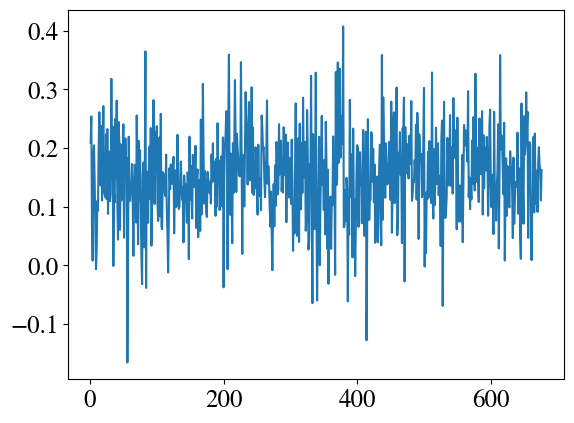

In [25]:
nfev = len(cost_history_SPSA_warmed)
import matplotlib.pyplot as plt
plt.plot(range(1,nfev+1), cost_history_SPSA_warmed)

In [ ]:
best_params = [4.04524932, 3.23021691, 1.56238008, 3.11652894, 1.14706909, 3.04243635,
 6.9368424,  2.1355254,  1.47385049]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz(circ,[0, 1, 2], out_f)
circ.save_statevector()
backend = AerSimulator()
t_circ = transpile(circ, backend)
job = backend.run(t_circ)
result = job.result()

psi_o = np.real(result.get_statevector(circ, decimals=100))

a0 = coefficient_set_2[0]*np.identity(8)                          #a0*Id

# TAKE CARE Z3 has to be interpreted reading the qubits backwards!!! in qiskit it is stored as little endian
# so q2 is the more important. |q0 q1 q2> is stored as |q2 q1 q0>
# so Z3 acts on q0 which is qctl[0]. which means that the kron product HAS TO BE FLIPPED
# AxBxC (theoretically)     --->     CxBxA   when acting on qctl 
a1 = coefficient_set_2[1]*np.kron(np.array([[1,0],[0,-1]]) , np.identity(4))           
A1 = np.add(a0, a1)

b = np.ones(8)/np.sqrt(8)   #real solution, theorically |b>   =   A1*|psi_o> / norm(A1*|psi_o>)
print(f"|psi_o>: {psi_o}")
print(f"A1*|psi_o> / norm(A1*|psi_o>): {np.matmul(A1,psi_o) / np.linalg.norm(np.matmul(A1,psi_o))}")
print(f"|b> : {b}")

#Inner product squared: | <b|   *     A1*|psi_o> / norm(A1*|psi_o>) |^2
print( ( np.matmul(b,np.matmul(A1,psi_o)) / np.linalg.norm(np.matmul(A1,psi_o)) )**2 )

norm_x_inverted =  np.matmul(b, np.matmul(A1,psi_o))
quantum_solution_x = psi_o / (norm_x_inverted)
print("quantum solution x: ",quantum_solution_x)
print("real solution x: ", np.linalg.solve(A1,b))


## 4. Acknowledgements

This implementation is based on the work presented in the research paper "Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles, which is available at [this](https://arxiv.org/abs/1909.05820) link.

In [ ]:
# import qiskit.tools.jupyter
# %qiskit_version_table

import qiskit
# import qiskit_terra   #DO NOT INSTALL, messes up qiskit
import qiskit_aer
import qiskit_ibm_runtime
import qiskit_algorithms

print("qiskit:", qiskit.__version__)
# print("qiskit-terra:", qiskit_terra.__version__)
print("qiskit-aer:", qiskit_aer.__version__)
print("qiskit-ibm-runtime:", qiskit_ibm_runtime.__version__)
print("qiskit-algorithms:", qiskit_algorithms.__version__)

qiskit: 2.2.3
qiskit-aer: 0.17.2
qiskit-ibm-runtime: 0.43.1
qiskit-algorithms: 0.4.0
